In [484]:
import os
os.environ['USE_PYGEOS'] = '0'
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx 
from shapely.geometry import Point, LineString
from shapely import distance
import numpy as np
from pyproj import Transformer
from shapely.geometry import LineString
import shapely.ops as sp_ops
import warnings
warnings.filterwarnings("ignore")

In [485]:
main_folder_path =os.path.normpath(os.getcwd() + os.sep + os.pardir)
df =pd.read_csv(main_folder_path+"\\data\\_roads3.csv")

In [486]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326")

In [487]:
from shapely import buffer  

In [488]:
road_names =gdf["road"].unique()
road_names_N1= [road for road in road_names if road.startswith("N")]
# print(road_names)
line_dict = {}
line_dict_test = {}
for road_name in road_names_N1:
    # if road_name.startswith('N'):
    bridges_road = gdf[gdf["road"] == road_name]
        # bridges_road=bridges_road.sort_ values(by=['km'])
    if len(bridges_road["geometry"]) >= 2:
            line =LineString(bridges_road["geometry"])
            line_transformed = sp_ops.transform(transformer.transform ,line).length
            if line_transformed > 25000:
                line_dict[road_name] =buffer(LineString(bridges_road["geometry"]),0.008)
                line_dict_test[road_name] =line

gseries =gpd.GeoSeries(line_dict.values(), index=line_dict.keys(), crs=4326)
gseries_test =gpd.GeoSeries(line_dict_test.values(), index=line_dict_test.keys(), crs=4326)

In [489]:
cross_index_N1=[]
for index in gseries.index:
    if gseries["N1"].intersects(gseries[index]):
        cross_index_N1.append(index)
cross_index_N2=[]
for index in gseries.index:
    if gseries["N2"].intersects(gseries[index]):
        cross_index_N2.append(index)

intersecting_N1 =gseries[gseries.index.isin(cross_index_N1)]
intersecting_N2 =gseries[gseries.index.isin(cross_index_N2)]

intersections_N1 =gseries["N1"].intersection(intersecting_N1).drop("N1")
intersections_N2 =gseries["N2"].intersection(intersecting_N2).drop("N2")

gdf_N1 =gdf[gdf["road"]=="N1"]
gdf_N2 =gdf[gdf["road"]=="N2"]

In [490]:
def process_intersection_data(gdf_data, intersect_data):
    df_list = []
    index_list = []
    closest_points = []
    empty_dataframe = gpd.GeoDataFrame(columns=list(gdf.columns)+["intersec_to"],crs="EPSG:4326")

    for intersect_index_N1 in intersect_data.index:
        intersect_point_N1 = intersect_data[intersect_index_N1]
        min_dist = 10000

        for N1_index in gdf_data.index:
            N1_point = gdf_data.loc[N1_index, "geometry"]
            dist = distance(N1_point, intersect_point_N1)

            if dist < min_dist:
                min_dist = dist
                closest_point = N1_index
        series = gdf_data.loc[closest_point]
        series["intersec_to"]=intersect_index_N1    
        empty_dataframe.loc[closest_point]=series


        index_list.append(intersect_index_N1)
        closest_points.append(closest_point)
    
    
    empty_dataframe["type"] = "intersection"
    
    return empty_dataframe

# Process intersection data for gdf_N1
df_intersections_main_N1 = process_intersection_data(gdf_N1, intersections_N1)

# Process intersection data for gdf_N2
df_intersections_main_N2 = process_intersection_data(gdf_N2, intersections_N2)
df_intersections_main =pd.concat([df_intersections_main_N1,df_intersections_main_N2], axis=0, ignore_index=True)
df_intersections_main.to_csv(main_folder_path+"\\data\\intersections_main.csv")

In [496]:
df_list = []
for road_name in intersections_N1.index:
    road_gdf = gdf[gdf["road"]==road_name]
    intersect_point_N1 =intersections_N1[road_name]
    min_dist=10000
    for road_point_index in road_gdf.index:
        road_point =road_gdf.loc[road_point_index,"geometry"]
        dist =distance(intersect_point_N1,road_point)
        if  dist< min_dist:
            min_dist = dist
            closest_point =road_point_index
    df_list.append(road_gdf[road_gdf.index == closest_point])
    
for road_name in intersections_N2.index:
    road_gdf = gdf[gdf["road"]==road_name]
    intersect_point_N2 =intersections_N2[road_name]
    min_dist=10000
    for road_point_index in road_gdf.index:
        road_point =road_gdf.loc[road_point_index,"geometry"]
        dist =distance(intersect_point_N2,road_point)
        if  dist< min_dist:
            min_dist = dist
            closest_point =road_point_index
    df_list.append(road_gdf[road_gdf.index == closest_point])  
    
df_intersections_side = pd.concat(df_list, axis=0, ignore_index=True)
df_intersections_side["type"]= "intersection"

df_intersections_side.to_csv(main_folder_path+"\\data\\intersections_side.csv")

<Axes: >

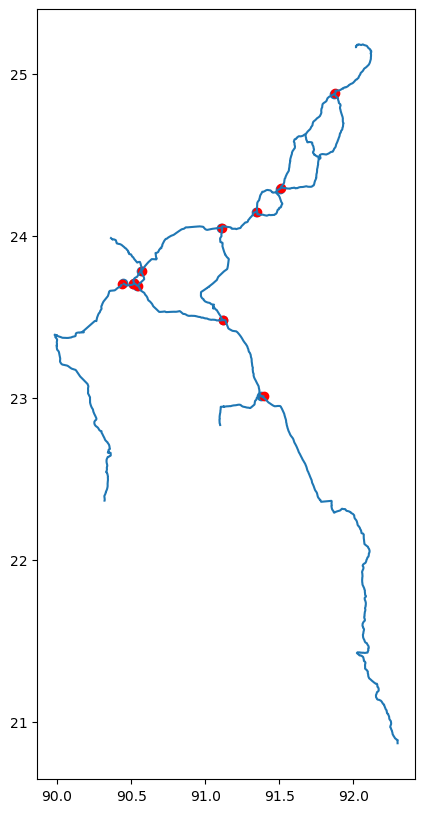

In [499]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
# Process intersection data for gdf_N1
df_intersections_main.plot(ax=ax)
gseries_test[gseries_test.index.isin(df_intersections_main["intersec_to"])].plot(ax=ax)
df_intersections_side.plot(ax=ax,color="red")
# Process intersection data for gdf_N2
# df_intersections_main_N2.plot(ax=ax)

In [ ]:
gseries_test[gseries_test.index.isin(df_intersections_main["intersec_to"])